In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
N=10
input = utils.generate_input_torch(N)
labels = torch.tensor([-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in range(2 ** N)]).reshape((-1, 1))

In [3]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}
kan_model = kan.KAN(width = [N, N, N, 1, 1])
kan_model(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [4]:
tanh = lambda x : torch.tanh(x)
kan_model.fix_symbolic(3, 0, 0, tanh)
kan_model.symbolic_fun[3].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype = torch.float64), requires_grad=False)
for i in range(N):
    for j in range(N):
        kan_model.fix_symbolic(0, j, i, 'x', verbose=False, log_history=False)

saving model version 0.1


In [5]:
kan_model.fit(dataset, steps=20, lamb=1.5e-4);

| train_loss: 1.30e-02 | test_loss: 1.30e-02 | reg: 1.54e+01 | : 100%|█| 20/20 [00:36<00:00,  1.82s/

saving model version 0.2


saving model version 0.3


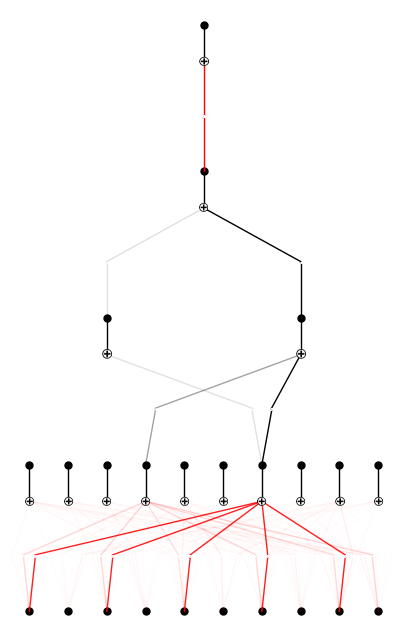

In [6]:
kan_model.prune().plot()

In [7]:
kan_model = kan_model.prune()
kan_model.symbolic_fun[3].affine = nn.Parameter(kan_model.symbolic_fun[3].affine.data, requires_grad=False)

saving model version 0.3


   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0       tan    0.903003 -3.365771           3                3   -1.456040
1       cos    0.799073 -2.315184           2                2   -1.020629
2       sin    0.799073 -2.315183           2                2   -1.020628
3       1/x    0.631202 -1.439057           2                2   -0.407340
4     1/x^3    0.704704 -1.759717           3                3   -0.331802
5     1/x^2    0.586880 -1.275333           2                2   -0.292733
6  gaussian    0.591489 -1.291518           3                3   -0.004063
7         0    0.000000  0.000014           0                0    0.000010
8         x    0.191705 -0.307028           1                1    0.085080
9       sgn    0.467820 -0.909988           3                3    0.263008


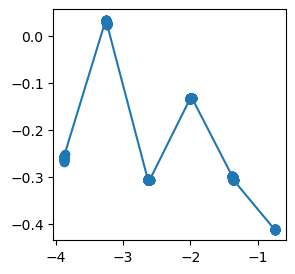

In [8]:
kan_model.suggest_symbolic(1, 6, 1, weight_simple=0.3, topk=10);
kan_model.get_fun(1, 6, 1);

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0  gaussian    0.987224 -6.289249           3                3   -3.502474
1       cos    0.899258 -3.311116           2                2   -1.717782
2       sin    0.898970 -3.307001           2                2   -1.714901
3       1/x    0.871818 -2.963626           2                2   -1.474538
4       sgn    0.902440 -3.357414           3                3   -1.450190
5       tan    0.869250 -2.935005           3                3   -1.154503
6      tanh    0.836687 -2.614198           3                3   -0.929938
7         x    0.638783 -1.469021           1                1   -0.728315
8       abs    0.777950 -2.170978           3                3   -0.619685
9     1/x^2    0.697177 -1.723404           2                2   -0.606383


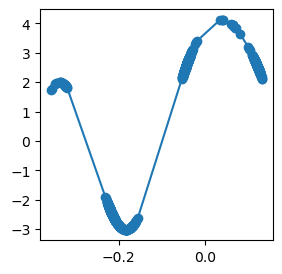

In [9]:
kan_model.suggest_symbolic(2, 1, 0, weight_simple=0.3, topk=10);
kan_model.get_fun(2, 1, 0);

In [10]:
kan_model.fix_symbolic(2, 1, 0, 'gaussian')
kan_model.fix_symbolic(1, 6, 1, 'tan')

Best value at boundary.
r2 is 0.9872236251831055
saving model version 0.4
r2 is 0.9030032753944397
saving model version 0.5


tensor(0.9030)

In [11]:
kan_model.fit(dataset, lamb=1.5e-4, steps=20);

| train_loss: 4.20e-03 | test_loss: 4.20e-03 | reg: 9.09e-03 | : 100%|█| 20/20 [00:25<00:00,  1.29s/

saving model version 0.6


In [12]:
kan_model(input), labels

(tensor([[-0.9965],
         [ 0.9952],
         [-0.9965],
         ...,
         [ 0.9952],
         [-0.9965],
         [ 0.9952]], grad_fn=<AddBackward0>),
 tensor([[-1],
         [ 1],
         [-1],
         ...,
         [ 1],
         [-1],
         [ 1]]))

saving model version 0.7


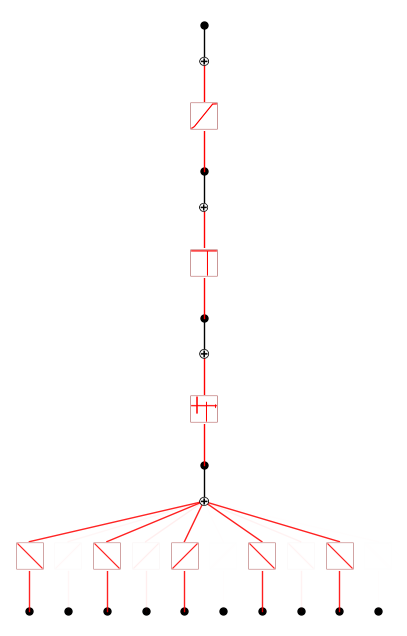

In [13]:
kan_model.prune().plot()

In [14]:
kan_model = kan_model.prune()
kan_model.symbolic_fun[3].affine = nn.Parameter(kan_model.symbolic_fun[3].affine.data, requires_grad=False)

saving model version 0.7


In [15]:
kan_model(input), labels

(tensor([[-0.8445],
         [ 0.9953],
         [-0.8194],
         ...,
         [ 0.9953],
         [-0.8129],
         [ 0.9953]], grad_fn=<AddBackward0>),
 tensor([[-1],
         [ 1],
         [-1],
         ...,
         [ 1],
         [-1],
         [ 1]]))

In [17]:
import dill
import inspect
def symbolic_formula(self, var=None, normalizer=None, output_normalizer = None):
    '''
    get symbolic formula

    Args:
    -----
        var : None or a list of sympy expression
            input variables
        normalizer : [mean, std]
        output_normalizer : [mean, std]
        
    Returns:
    --------
        None

    Example
    -------
    >>> from kan import *
    >>> model = KAN(width=[2,1,1], grid=5, k=3, noise_scale=0.0, seed=0)
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=3)
    >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
    >>> model.auto_symbolic()
    >>> model.symbolic_formula()[0][0]
    '''
    
    symbolic_acts = []
    symbolic_acts_premult = []
    x = []

    def ex_round(ex1, n_digit):
        ex2 = ex1
        for a in sympy.preorder_traversal(ex1):
            if isinstance(a, sympy.Float):
                ex2 = ex2.subs(a, round(a, n_digit))
        return ex2

    # define variables
    if var == None:
        for ii in range(1, self.width[0][0] + 1):
            exec(f"x{ii} = sympy.Symbol('x_{ii}')")
            exec(f"x.append(x{ii})")
    elif isinstance(var[0], sympy.Expr):
        x = var
    else:
        x = [sympy.symbols(var_) for var_ in var]

    x0 = x

    if normalizer != None:
        mean = normalizer[0]
        std = normalizer[1]
        x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

    symbolic_acts.append(x)

    for l in range(len(self.width_in) - 1):
        num_sum = self.width[l + 1][0]
        num_mult = self.width[l + 1][1]
        y = []
        for j in range(self.width_out[l + 1]):
            yj = 0.
            for i in range(self.width_in[l]):
                a, b, c, d = self.symbolic_fun[l].affine[j, i]
                sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                try:
                    yj += c * sympy_fun(a * x[i] + b) + d
                except:
                    # sympy_fun = sympy.Function(f'{sympy_fun=}'.split('=')[0])
                    sympy_fun = sympy.Function(f'({inspect.getsource(sympy_fun)})')
                    yj += c * sympy_fun(a * x[i] + b) + d
                    # yj += c * sympy.tanh(a * x[i] + b) + d
                    print('make sure all activations need to be converted to symbolic formulas first!')
                    # return
            yj = self.subnode_scale[l][j] * yj + self.subnode_bias[l][j]
            y.append(yj)
                
        symbolic_acts_premult.append(y)
            
        mult = []
        for k in range(num_mult):
            if isinstance(self.mult_arity, int):
                mult_arity = self.mult_arity
            else:
                mult_arity = self.mult_arity[l+1][k]
            for i in range(mult_arity-1):
                if i == 0:
                    mult_k = y[num_sum+2*k] * y[num_sum+2*k+1]
                else:
                    mult_k = mult_k * y[num_sum+2*k+i+1]
            mult.append(mult_k)
            
        y = y[:num_sum] + mult
        
        for j in range(self.width_in[l+1]):
            y[j] = self.node_scale[l][j] * y[j] + self.node_bias[l][j]
        
        x = y
        symbolic_acts.append(x)

    if output_normalizer != None:
        output_layer = symbolic_acts[-1]
        means = output_normalizer[0]
        stds = output_normalizer[1]

        assert len(output_layer) == len(means), 'output_normalizer does not match the output layer'
        assert len(output_layer) == len(stds), 'output_normalizer does not match the output layer'
        
        output_layer = [(output_layer[i] * stds[i] + means[i]) for i in range(len(output_layer))]
        symbolic_acts[-1] = output_layer


    self.symbolic_acts = [[symbolic_acts[l][i] for i in range(len(symbolic_acts[l]))] for l in range(len(symbolic_acts))]
    self.symbolic_acts_premult = [[symbolic_acts_premult[l][i] for i in range(len(symbolic_acts_premult[l]))] for l in range(len(symbolic_acts_premult))]

    out_dim = len(symbolic_acts[-1])
    #return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0
    return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0

In [18]:
ku.ex_round(symbolic_formula(kan_model)[0][0], 4)

make sure all activations need to be converted to symbolic formulas first!


1.0*(tanh = lambda x : torch.tanh(x)
)(3.0262 - 6.193*exp(-0.398*(1 - 0.5992*tan(1.5255*x_1 + 0.0079*x_10 - 0.0414*x_2 + 1.5836*x_3 - 0.079*x_4 - 1.6181*x_5 - 0.0103*x_6 + 1.6231*x_7 + 0.0582*x_8 + 1.5666*x_9 + 9.4769))**2))

In [10]:
kan_model.fix_symbolic(2, 1, 0, 'x');

Best value at boundary.
r2 is 0.7962786555290222
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.103


In [13]:
ku.fit_params(kan_model.acts[2][:, 1], kan_model.spline_postacts[2][:, 0, 1], lambda x : x)

Best value at boundary.
r2 is 0.7962786555290222
r2 is not very high, please double check if you are choosing the correct symbolic function.


(tensor([-1.0000e+01,  0.0000e+00,  3.1233e-03,  2.6871e-02]), tensor(0.7963))